In [1]:
#MAKE SURE YOU CD TO 3D LightHOUSE
#Need To Change Kernel
#Install environment need to make it visible to Juypter
#sometimes mamba is faster for installment 

#Run in Terminal 
%%bash
source /opt/conda/bin/activate opensfm
export PATH=$PATH:/opt/utils/OpenSfM/bin
mamba install -y 'numpy>=1.19,<2.0.0'

SyntaxError: invalid syntax (2102802608.py, line 7)

In [1]:
# !conda install plotly -y

| 

In [1]:
#Open as Reg Juypter Notebook Switch to OpenSFM
import cv2
import numpy as np
from matplotlib import pyplot as plt
#import pandas as pd
import os
import sys
import pathlib
#import open3d as o3d
#import plotly
#import plotly.graph_objects as go

In [2]:
import os
current_directory = os.getcwd()

print(f"The current working directory is: {current_directory}")

The current working directory is: /home/jovyan/3D_LightHouse


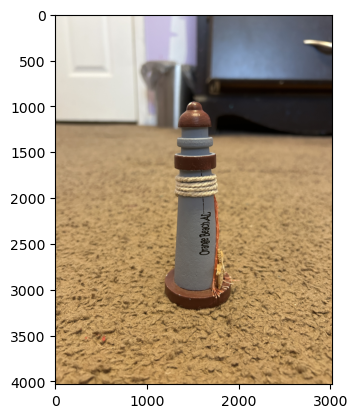

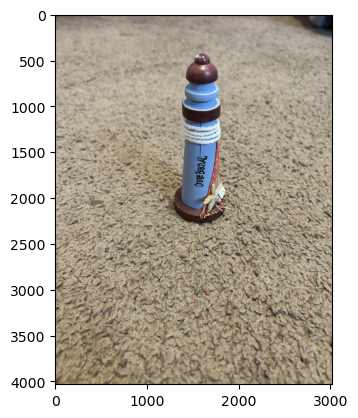

In [4]:
img1 = cv2.imread("LightHouse/images/IMG_7112.jpeg", cv2.IMREAD_COLOR)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_rgb)
plt.show()

img2 = cv2.imread("LightHouse/images/IMG_7190.jpeg", cv2.IMREAD_COLOR)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2_rgb)
plt.show()

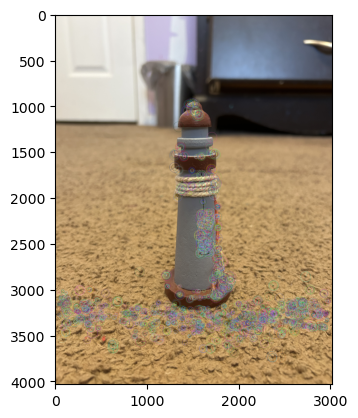

In [5]:
MAX_FEATURES = 5000

# creating the ORB feature extractor
#Orb is based on sift
#we are using open source verison
orb = cv2.ORB_create(MAX_FEATURES)

# creating feature points for first and second images
kp1, dc1 = orb.detectAndCompute(img1_rgb, None)
kp2, dc2 = orb.detectAndCompute(img2_rgb, None)

img1_ORB = cv2.drawKeypoints(img1_rgb, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1_ORB)
plt.show()

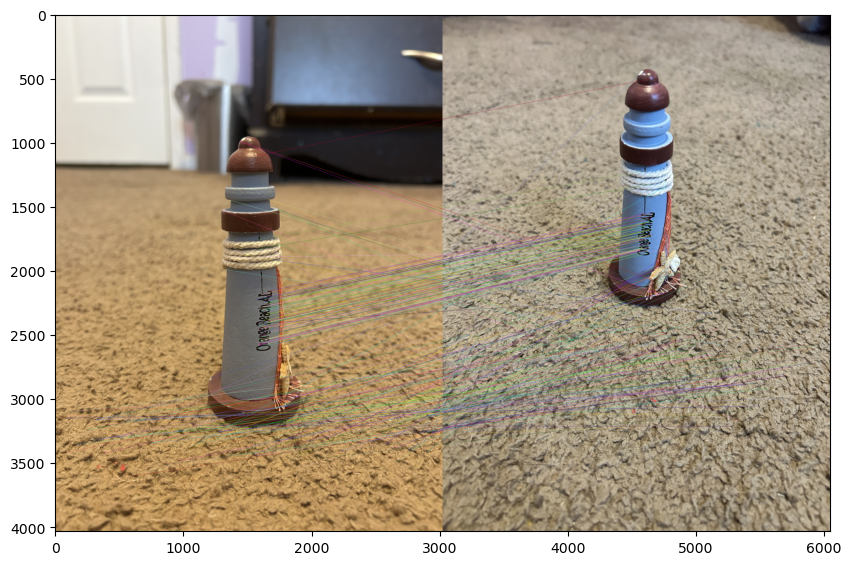

In [6]:
# most matches are not very good, so we want to keep only the best ones.
# here, we keep only the top 20%
GOOD_MATCH_PERCENT = 0.2

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# match descriptors
matches = bf.match(dc1, dc2)
matches = list(matches)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove worst matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

img_match = cv2.drawMatches(img1_rgb,kp1,img2_rgb,kp2,matches,None, flags=2)
plt.figure(figsize=(10,10))
plt.imshow(img_match)
plt.show()

pts1 = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
pts2 = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

In [7]:
!pip install exifread
import exifread
with open("LightHouse/images/IMG_7112.jpeg", 'rb') as image_file:
    tags = exifread.process_file(image_file, details=False)
    print(tags) #PNG Files do not have EXIF but JPG does
    print(img1.shape)

  Using cached ExifRead-3.0.0-py3-none-any.whl.metadata (6.4 kB)
Using cached ExifRead-3.0.0-py3-none-any.whl (40 kB)
{'Image Make': (0x010F) ASCII=Apple @ 158, 'Image Model': (0x0110) ASCII=iPhone 14 @ 164, 'Image Orientation': (0x0112) Short=Rotated 90 CW @ 42, 'Image XResolution': (0x011A) Ratio=72 @ 174, 'Image YResolution': (0x011B) Ratio=72 @ 182, 'Image ResolutionUnit': (0x0128) Short=Pixels/Inch @ 78, 'Image Software': (0x0131) ASCII=17.5.1 @ 190, 'Image DateTime': (0x0132) ASCII=2024:07:26 15:29:52 @ 198, 'Image HostComputer': (0x013C) ASCII=iPhone 14 @ 218, 'Image YCbCrPositioning': (0x0213) Short=Centered @ 126, 'Image ExifOffset': (0x8769) Long=228 @ 138, 'GPS GPSLatitudeRef': (0x0001) ASCII=N @ 2470, 'GPS GPSLatitude': (0x0002) Ratio=[34, 44, 5617/100] @ 2646, 'GPS GPSLongitudeRef': (0x0003) ASCII=W @ 2494, 'GPS GPSLongitude': (0x0004) Ratio=[86, 38, 43] @ 2670, 'GPS GPSAltitudeRef': (0x0005) Byte=0 @ 2518, 'GPS GPSAltitude': (0x0006) Ratio=585202/2627 @ 2694, 'GPS GPSTime

In [11]:
!cd ..
!cd 07-3D_Reconstruction_and_SfM
import numpy as np
K = np.load('camera_mat.npy')

# converting to pixel coordinates
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Estimate the essential matrix
E, mask = cv2.findEssentialMat(pts1,pts2,K)

# We select only inlier points
pts1_inliers = (pts1[mask.ravel()==1])
pts2_inliers = (pts2[mask.ravel()==1])

retval, R, t, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)
print(R)
print(t)

/bin/bash: line 1: cd: 07-3D_Reconstruction_and_SfM: No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: 'camera_mat.npy'

In [1]:
#2 Reset
import os, shutil
# shutil.rmtree("LightHouse/images")
shutil.rmtree("LightHouse/matches")
shutil.rmtree("LightHouse/exif")
shutil.rmtree("LightHouse/features")
shutil.rmtree("LightHouse/reports")
# shutil.rmtree("New_Attempt")

In [9]:
#Run in OpenSFM Terminal Env
opensfm extract_metadata LightHouse/

opensfm detect_features LightHouse/

opensfm match_features LightHouse/

opensfm create_tracks LightHouse/
opensfm reconstruct LightHouse/
opensfm export_ply LightHouse/

In [4]:
#Switch
import open3d as o3d
import plotly
import plotly.graph_objects as go
import numpy as np

In [5]:
def get_colors_from_ply(plyfile):
    '''
    Function to read the colors from a .ply file
    returns an RGB array scaled between [0,1]
    '''
    with open(plyfile, 'r') as f:
        colors = []
        columns = {}
        col_idx = 0
        header_done = False
        for line in f.readlines():
            if line.startswith('property'):
                columns[line.split()[-1]] = col_idx
                col_idx += 1
            if header_done:
                line_list = line.split()
                colors.append([float(line_list[columns['red']]),
                              float(line_list[columns['green']]),
                              float(line_list[columns['blue']])
                              ])
            if line.startswith('end_header'):
                header_done = True
        colors = np.array(colors)/255
    return colors
        

In [6]:

# read point cloud data
pcd = o3d.io.read_point_cloud("LightHouse/reconstruction.ply", format='ply')
# store the colors
pcd.colors = o3d.utility.Vector3dVector(get_colors_from_ply('LightHouse/reconstruction.ply'))

# convert to array
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=5, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.write_html('please3.html')
